In [1]:
#Importing all the needed packages and subpackages. 
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 14 09:19:54 2022

@author: vivianliu
adopted for jupyter notebook by Alexa Halford
"""
#from dask.distributed import Client

#client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
#client

#import dask.dataframe as dd

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import copy
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score



In [2]:
# Here we are putting in the information that needs to be hardcoded into 
# the jupyter notbook runs. 

#   data: a data frame or string pathname type
data = "../../../Data/combined_data_all_reduced_omni.csv"

#   target_variable: string with target variable name
target_variable = '400kmDensity'

#Below is our "Standard model" for what we want to compare to. 
#   features (optional): takes a list type with the names of all the 
#                        variables to include. Default is all
Stand_features = ["DAILY_F10.7_", "MagTime","SLat", "SYM/H_INDEX_nT"] #"DipLat", 
                  #"SYM/H_INDEX_nT"]#, "1-M_AE_nT", "3-H_KP*10_"]

#need to add in variations of sort of latitude, magnetic lat, geographic lat, solar zenith angle, etc

#There are some features we want for plotting - like date - 
#but don't want for creating the model so we identify those here. 
drop_features = ["year", "hour", "minute", "second"] #None


#   estimators (optional): integer for number of estimators in 
#                       random forest. Default is 150
estimators = 150


#   TrainUpTo (optional): A 4 digit year input that allows users to 
#                       select training data before inputted year
TrainUpTo = 2008 #None


#   rdm_state (optional): integer for random state of random 
#                        forest regression. Defult is 16
rdm_state = 16


#   test_portion (optional): float between 0 and 1 for 
#                         proportion of data used for test. 
#                         Default is 0.25
test_portion = 0.25



In [3]:
#Further preparing the data 

#Create a dataframe based on data input method
#if (type(data) == pd.core.frame.DataFrame):
#    merged_df = data;
#elif (type(data) == str):
#    merged_df = pd.read_csv(data)

merged_df = pd.read_csv(data)
a = np.array(merged_df.keys())
#merged_df = dd.read_csv(data)
    
#Sort by data for easier reading
merged_df = merged_df.sort_values(by = "Datetime")
merged_df = merged_df.reset_index(drop = True)
    
#Get rid of any rows outside of expected date range
#This needed to be done as there were some bad date and data
merged_df = merged_df[~(merged_df["Datetime"] < '2002-05-01')]

#Remove datetime column for random forest
merged_df = merged_df.drop("Datetime", axis = 1)

#Set target and feature variables
target = merged_df[target_variable]
target = target*(10**12)
merged_df = merged_df.drop(target_variable, axis = 1)


In [4]:
#Here we are starting to build up the different models by making 
#sure they have the right inputs/outputs. 
#Adjust features being used based on user input

#First we start with the 'standard' model
#Stand_list = list(merged_df.columns)
STmodel_features = ["year", "month", "day", "hour", "minute", "second"]
for element in Stand_features:
    STmodel_features.append(element)
Stand_list = STmodel_features
merged_df = merged_df[Stand_list]
a = merged_df.keys()
for i in range(len(Stand_list)):
    if a[i] in Stand_list:
        print(a[i], 'is being kept')
    else:
        del Stand_list[a[i]]


year is being kept
month is being kept
day is being kept
hour is being kept
minute is being kept
second is being kept
DAILY_SUNSPOT_NO_ is being kept
MagTime is being kept
SLat is being kept
3-H_KP*10_ is being kept


In [5]:
###Set training and testing groups###
    
#If no testing set specified, create random testing and training groups
if (TrainUpTo == None):
    train_features, test_features, train_target, test_target = train_test_split(merged_df, target, test_size = test_portion, random_state = rdm_state)
else:
    #Choose training and testing data
    train_features = merged_df[merged_df.year <= TrainUpTo]
    size = len(train_features.index)
    test_features = merged_df.iloc[size:]
    train_target = target.iloc[0:size]
    test_target = target.iloc[size:]
    


In [6]:
#Create new variables to hold current dataframe which has datetime values in case they are dropped
#Used for graphing predicted and true values based on date
graph_df = merged_df
Stand_list_u = Stand_list.copy()
test_features_u = test_features


In [7]:
#Drop features that user specifies so that they aren't included in the random forest
if (drop_features != None):
    train_features = train_features.drop(drop_features, axis = 1)
    test_features = test_features.drop(drop_features, axis = 1)   
    for element in drop_features:
        Stand_list.remove(element)


In [8]:
#Train and fit the model
rf = RandomForestRegressor(n_estimators = estimators, random_state = rdm_state)
rf.fit(train_features, train_target)


RandomForestRegressor(n_estimators=150, random_state=16)

In [10]:

#Make predictions and calculate error
predictions = rf.predict(test_features)

#Print the mean absolute error
mean_abs_error = mean_absolute_error(test_target, predictions)
print("\nMean Absolute Error: ", mean_abs_error, " kg/m^3.")

#Print mean absolute percentage error
mape = mean_absolute_percentage_error(test_target, predictions)
print("Mean Absolute Percentage Error: ", mape)



Mean Absolute Error:  0.5409148211519249  kg/m^3.
Mean Absolute Percentage Error:  0.6330744500669149


In [11]:
#Print r-squared score of model
score = r2_score(test_target, predictions)
#print("Score: ", score)

#Examine feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(Stand_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

print('For the standard model')
print("Score: ", score)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
print()
print()



For the standard model
Score:  0.5341096150778781
Variable: DAILY_SUNSPOT_NO_    Importance: 0.56
Variable: month                Importance: 0.15
Variable: MagTime              Importance: 0.12
Variable: day                  Importance: 0.06
Variable: 3-H_KP*10_           Importance: 0.06
Variable: SLat                 Importance: 0.05




/Users/alexahalford/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/alexahalford/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/alexahalford/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/alexahalford/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for 

/Users/alexahalford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/alexahalford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


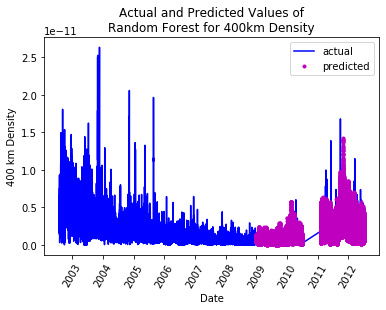

In [13]:

#Create arrays for the datetime values for the true data
months = graph_df.iloc[:, Stand_list_u.index('month')]
days = graph_df.iloc[:, Stand_list_u.index('day')]
years = graph_df.iloc[:, Stand_list_u.index('year')]
hours = graph_df.iloc[:, Stand_list_u.index('hour')]
minutes = graph_df.iloc[:, Stand_list_u.index('minute')]
seconds = graph_df.iloc[:, Stand_list_u.index('second')]
    
#Convert datetime arrays to datetime type
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) + " " + str(int(hour)) + ":" + str(int(minute)) + ":" + str(int(second)) for year, month, day, hour, minute, second in zip(years, months, days, hours, minutes, seconds)]
dates = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in dates]
    
#Create dataframe using datetime and target data
true_data = pd.DataFrame(data = {'date': dates, 'actual': target})
true_data = true_data.sort_values(by = "date")
true_data["actual"] = true_data["actual"] / (10**12)
    
#Create arrays for the datetime values for the predicted data
months = test_features_u.iloc[:, Stand_list_u.index('month')]
days = test_features_u.iloc[:, Stand_list_u.index('day')]
years = test_features_u.iloc[:, Stand_list_u.index('year')]
hours = test_features_u.iloc[:, Stand_list_u.index('hour')]
minutes = test_features_u.iloc[:, Stand_list_u.index('minute')]
seconds = test_features_u.iloc[:, Stand_list_u.index('second')]
    
#Convert datetime arrays to datetime type
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) + " " + str(int(hour)) + ":" + str(int(minute)) + ":" + str(int(second)) for year, month, day, hour, minute, second in zip(years, months, days, hours, minutes, seconds)]
test_dates = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in test_dates]
    
#Make a new dataframe with prediction data
prediction_data = pd.DataFrame(data = {"dates": test_dates, "predictions": predictions})
prediction_data = prediction_data.sort_values(by = "dates")
prediction_data["predictions"] = prediction_data["predictions"] / (10**12)
    
#Plot the true values in blue
plt.plot(true_data["date"], true_data["actual"], "b-", label = "actual")
#Plot predicted values in magenta
plt.plot(prediction_data["dates"], prediction_data["predictions"], "mo", label = "predicted", markersize = 3)
    
    
#Label Plot
plt.xticks(rotation = 60)
plt.xlabel("Date")
plt.ylabel("400 km Density")
plt.title("Actual and Predicted Values of\nRandom Forest for 400km Density")
plt.legend()